# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


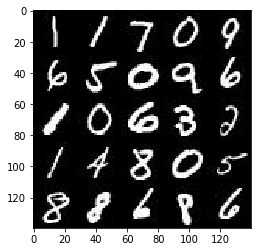

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

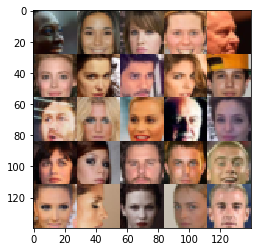

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(None), name="learning_rate")
    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.4)
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same' , kernel_regularizer=regularizer)
        lr = tf.maximum(alpha * h1, h1)
        # ?x14x14x64
        
        h2 = tf.layers.conv2d(lr, 128, 5, strides=2, padding='same' , kernel_regularizer=regularizer)
        bn1 = tf.layers.batch_normalization(h2, training=True)
        lr2 = tf.maximum(alpha * bn1, bn1)
        drop2 = tf.nn.dropout(lr2, 0.7)
        # ?x7x7x128
        
        h3 = tf.layers.conv2d(lr2, 256, 5, strides=2, padding='same' , kernel_regularizer=regularizer)
        bn2 = tf.layers.batch_normalization(h3, training=True)
        lr3 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(lr3, 0.7)
        # ?x4x4x256
        
        #h4 = tf.layers.conv2d(lr3, 1024, 5, strides=2, padding='same', kernel_regularizer=regularizer)
        #bn3 = tf.layers.batch_normalization(h4, training=True)
        #lr4 = tf.maximum(alpha * bn3, bn3)
        #drop3 = tf.nn.dropout(lr4, 0.7)
        # ?x2x2x512
        
        flatten = tf.reshape(drop2, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 7*7*512)
        h1_n = tf.nn.l2_normalize(h1, dim=-1, epsilon=1e-12)
        h1_r = tf.reshape(h1_n, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(h1_r, training=is_train)
        lr1 = tf.maximum(alpha * bn1, bn1)
        # ?x7x7x1024
        
        h2 = tf.layers.conv2d_transpose(lr1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lr2 = tf.maximum(alpha * bn2, bn2)
        drop = tf.nn.dropout(lr2, 0.5)
        # ?x14x14x256
        
        h3 = tf.layers.conv2d_transpose(lr2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lr3 = tf.maximum(alpha * bn3, bn3)
        drop2 = tf.nn.dropout(lr3, 0.5)
        # ?x14x14x128        
        
        
        #h4 = tf.layers.conv2d_transpose(lr3, 64, 5, strides=1, padding='same', kernel_regularizer=regularizer)
        #bn4 = tf.layers.batch_normalization(h4, training=is_train)
        #lr4 = tf.maximum(alpha * bn4, bn4)
        #drop = tf.nn.dropout(lr4, 0.6)
        # ?x14x14x128
        
        logits = tf.layers.conv2d_transpose(drop2, out_channel_dim, 5, strides=1, padding='same')
        #drop3 = tf.nn.dropout(logits, 0.6)
        # ?x28x28x64
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #smoothing = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width, img_height, img_channels = data_shape[1], data_shape[2], data_shape[3]
    inputs_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every =  100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 3.3806
Epoch 1/1... Discriminator Loss: 2.8317... Generator Loss: 0.1608
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 2.9702
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0332


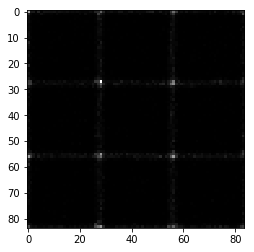

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.4189


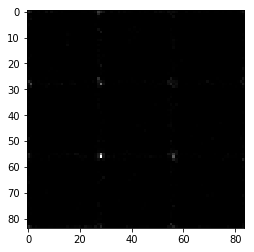

Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 2.5958
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.9694
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.7413


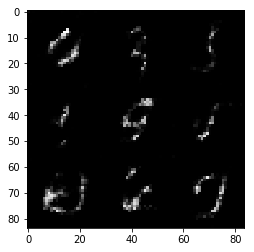

Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.5802


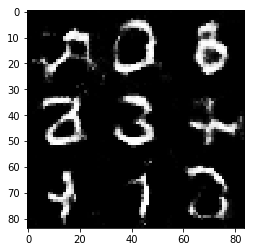

Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.8671... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.4226


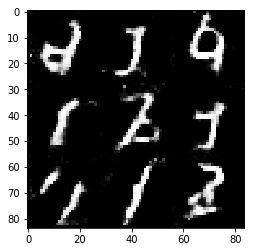

Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.6620
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9212


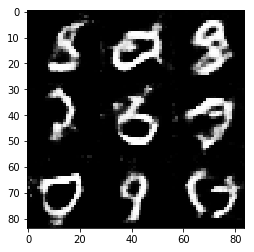

Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.5047
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.9893
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.1703
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 2.0402
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 2.3445


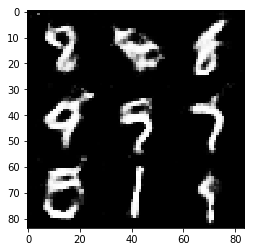

Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.6230


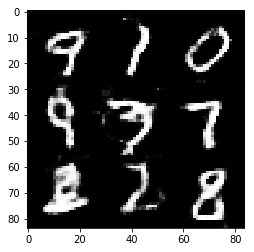

Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.8172
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.0687


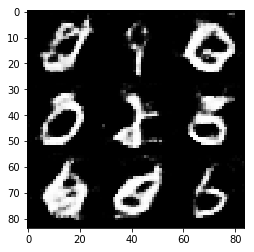

Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.4756


In [20]:
batch_size = 64 #best at 32 so far - tested: 50 32(-)
z_dim = 100 #best at 100 so far - tested 150(F) 200(?) 400(?)
learning_rate = 0.0002
beta1 = 0.5

#top hp's
#batch_size = 64 #best at 32 so far - tested: 50(-) 32(-) 16(F)
#z_dim = 100 #best at 100 so far - tested 150(F) 128(?)
#learning_rate = 0.0002 #best at 0.0002 - tested: 0.00035(-) 0.0004(-) 0.0005(F) 0.0015(F)
#beta1 = 0.5 #best at 0.5 - tested: 0.3(-) 0.4(?) 0.7(F) 0.1(F)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA

Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 3.7261
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.7088
Epoch 1/1... Discriminator Loss: 0.2618... Generator Loss: 15.9315
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 11.1804
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 2.3669
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 0.0750... Generator Loss: 4.4176
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 3.9705
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 4.8234


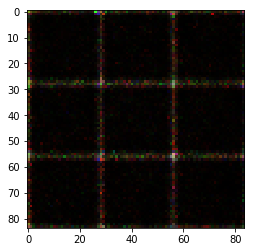

Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 2.4979
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.8409... Generator Loss: 4.8310


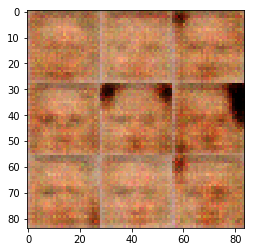

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 2.0890
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 2.0636
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.6434
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 2.2051... Generator Loss: 0.2682


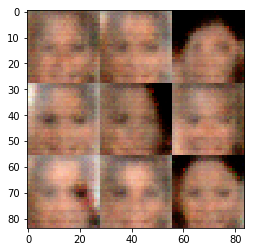

Epoch 1/1... Discriminator Loss: 2.1767... Generator Loss: 0.1688
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 2.1808... Generator Loss: 3.0135
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 2.2111... Generator Loss: 2.9245
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.4510
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.9782


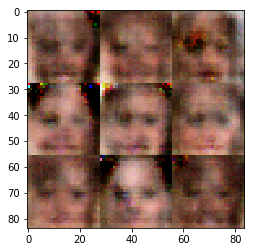

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.3075


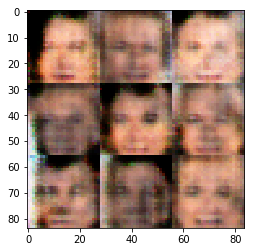

Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 1.6971... Generator Loss: 2.5849
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 2.4622
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.6238


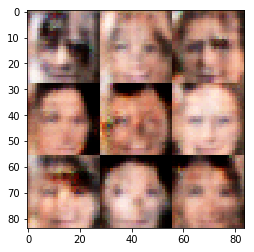

Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.7546... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.7949... Generator Loss: 0.2846
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 2.2974
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.6712


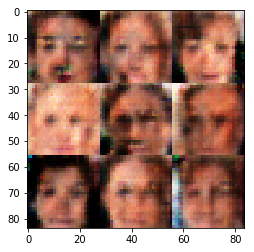

Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.7008
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.8935... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5141


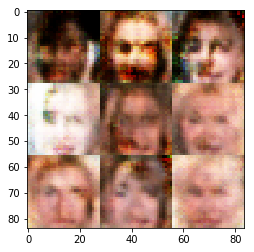

Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7392


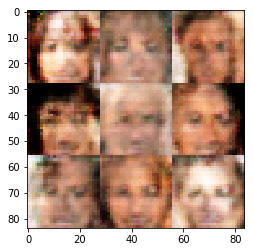

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.8603


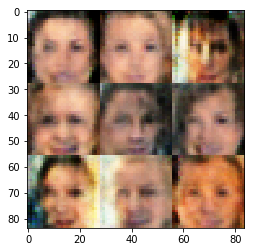

Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.4664
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1751


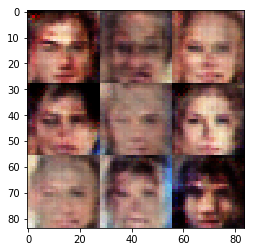

Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5917


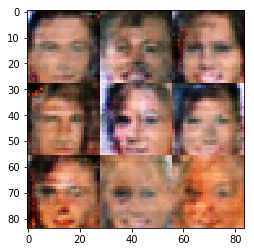

Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.5832


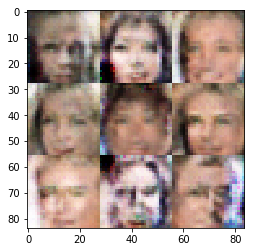

Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7040


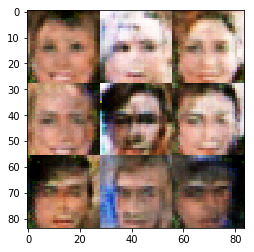

Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.9647


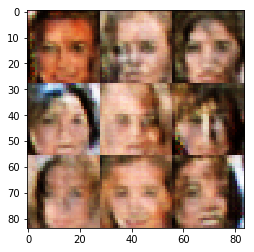

Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6537


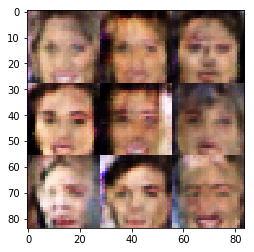

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8408


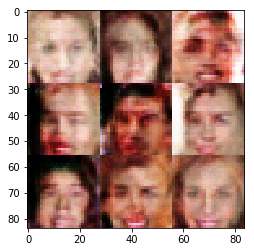

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6319


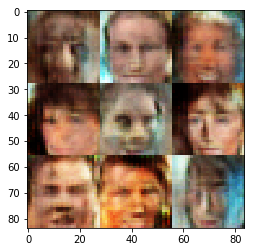

Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.7655... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7445


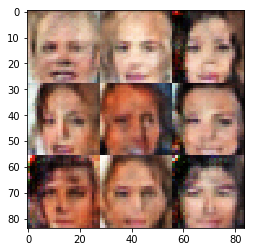

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9487


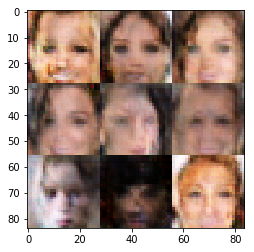

Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7395


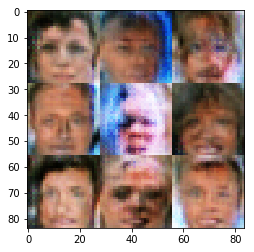

Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8813


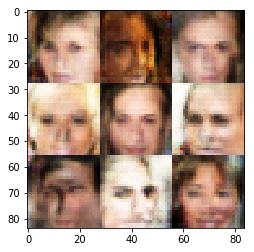

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6042


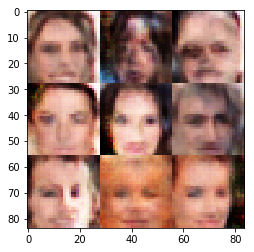

Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9208


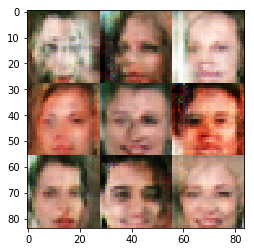

Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6575


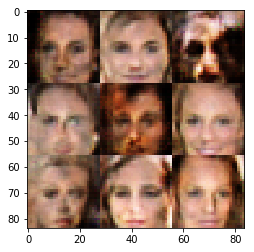

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7360


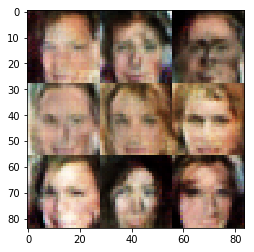

Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7827


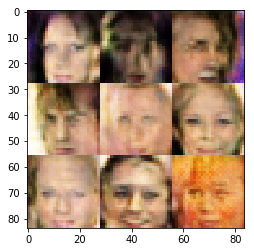

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7248


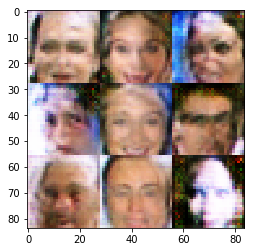

Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6196


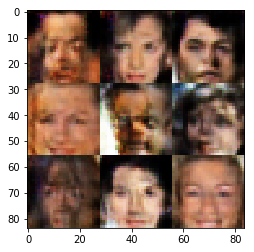

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6417


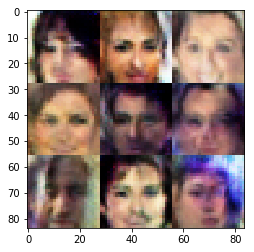

Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.6887


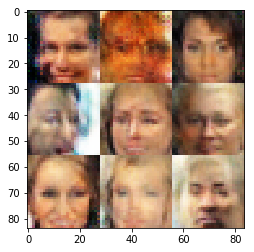

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7229


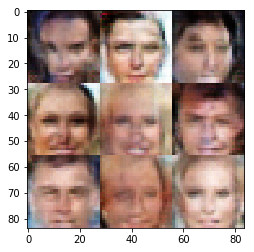

Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6594


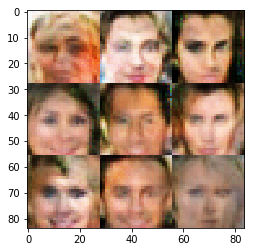

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6982


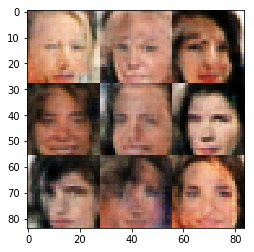

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5948


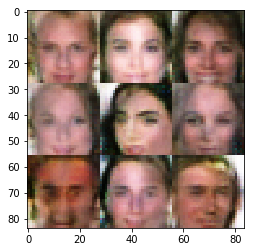

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6854


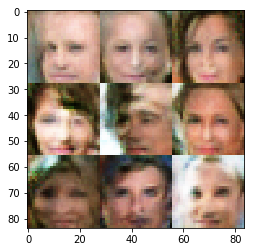

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.9024


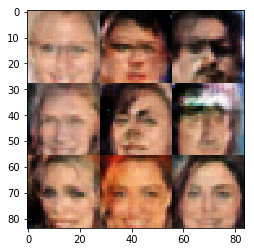

Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7225


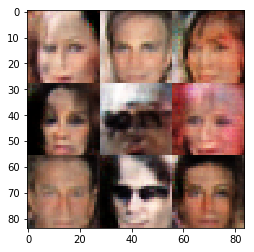

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6446


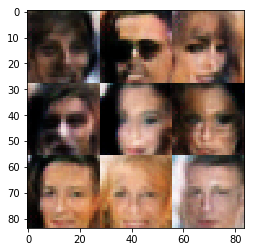

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6605


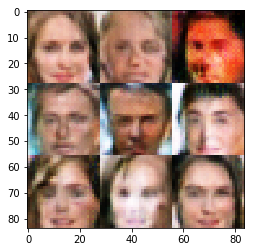

Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7279


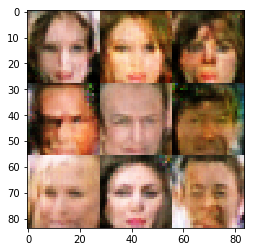

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6909


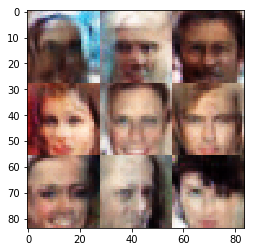

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6913


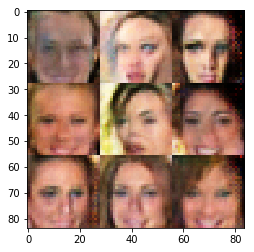

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7940


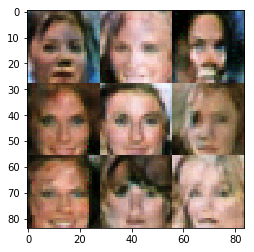

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7054


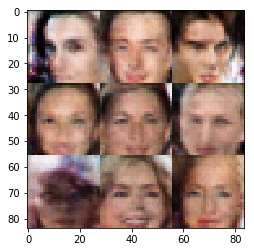

Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6394


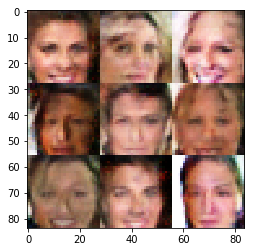

Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.6088


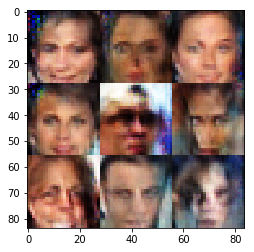

Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6726


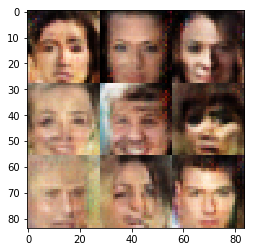

Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8097


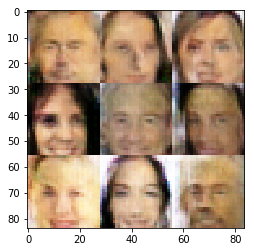

Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6513


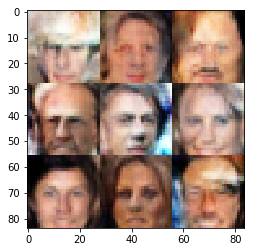

Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.5504


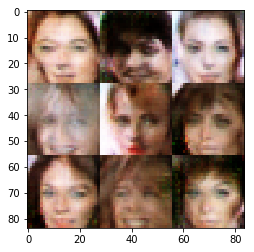

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.9552


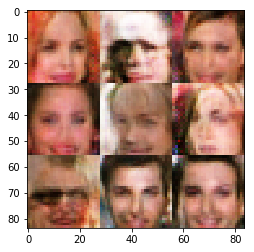

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7047


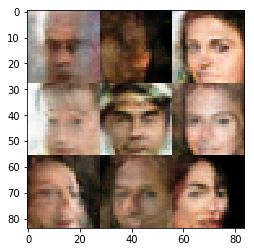

Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7018


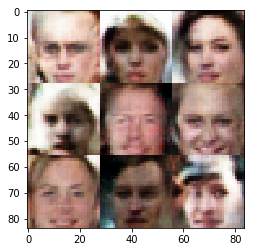

Epoch 1/1... Discriminator Loss: 1.7532... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7739


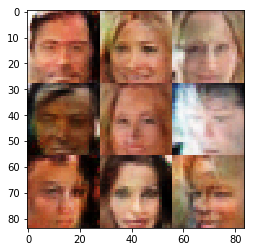

Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6400


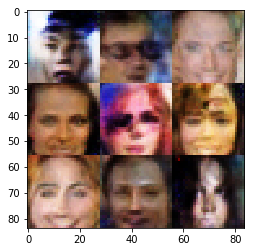

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7117


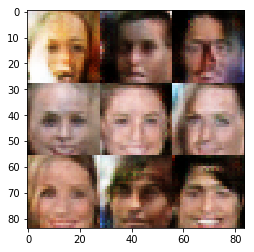

Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8374


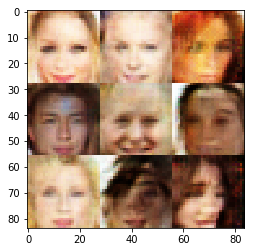

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6515


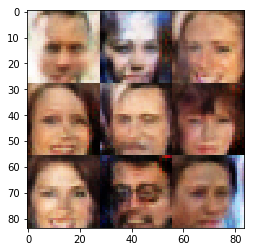

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6252


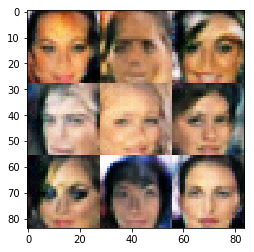

Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7361


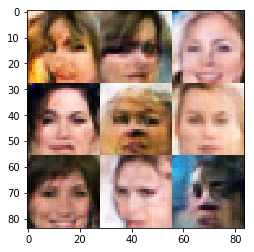

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9228


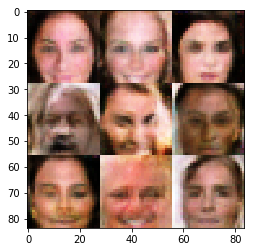

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.6928


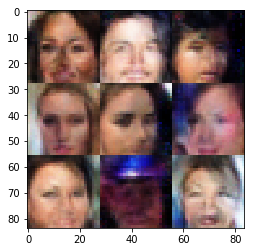

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7856


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.6


#top hp's
#batch_size = 32 #best at 32 so far - tested: 50(?) 64(-) 16(F)
#z_dim = 100 #best at 100 so far - tested 150(F) 250(F) 120(-) 116(?)
#learning_rate = 0.0006 #best at 0.0006 - tested: 0.0002(-) 0.0004(?) 0.00035(?) 0.0003(-) 0.002(F)
#beta1 = 0.6 #best at 0.6  - tested: 0.7(F) 0.4(-) 0.3(-) 0.2(F)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.